In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from google.colab import files
uploaded = files.upload()

Saving ResizeDataset (2).zip to ResizeDataset (2).zip


In [ ]:
!unzip -uq "/content/ResizeDataset.zip" -d "/content"

In [90]:
import tensorflow as tf
import tensorflow_hub as hub
import os
from keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers


In [91]:
train_dir='/content/drive/MyDrive/Buffml/code/Training/Dataset'

In [92]:
Labels = ['Benign', 'Malignant']

In [93]:
print ("class : ") 
for i in range(len(Labels)): 
    print (i, end = " ") 
    print (Labels[i]) 

class : 
0 Benign
1 Malignant


In [96]:
print('Number of classes:',len(Labels))

Number of classes: 2


In [97]:
module_selection = ("mobilenet_v2", 224, 1280) 
handle_base, pixels, FV_SIZE = module_selection
MODULE_HANDLE ="https://tfhub.dev/google/tf2-preview/{}/feature_vector/2".format(handle_base)
IMAGE_SIZE = (pixels, pixels)
BATCH_SIZE = 16 

In [98]:
IMAGE_SIZE

(224, 224)

In [99]:
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
      rescale = 1./255,
      rotation_range=40,
      horizontal_flip=True,
      width_shift_range=0.2, 
      height_shift_range=0.2,
      shear_range=0.2, 
      zoom_range=0.2,
      fill_mode='nearest',
      validation_split=0.4)
  
train_generator = train_datagen.flow_from_directory(
    train_dir, 
    subset="training", 
    shuffle=True, 
    seed=42,
    color_mode="rgb", 
    class_mode="categorical",
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE)

validation_generator = train_datagen.flow_from_directory(
    train_dir, 
    shuffle=False, 
    seed=42,
    color_mode="rgb", 
    class_mode="categorical",
    subset="validation",
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE)

Found 24 images belonging to 2 classes.
Found 16 images belonging to 2 classes.


In [100]:
feature_extractor = hub.KerasLayer(MODULE_HANDLE,input_shape=IMAGE_SIZE+(3,), output_shape=[FV_SIZE]  )


In [101]:
do_fine_tuning = False 
if do_fine_tuning:
  feature_extractor.trainable = True
  for layer in base_model.layers[-30:]:
    layer.trainable =True
  
else:
  feature_extractor.trainable = False

In [102]:
print("Building model with", MODULE_HANDLE)
model = tf.keras.Sequential([
    feature_extractor,
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dropout(rate=0.2),
    tf.keras.layers.Dense(train_generator.num_classes, activation='softmax',
                           kernel_regularizer=tf.keras.regularizers.l2(0.0001))
])
#model.build((None,)+IMAGE_SIZE+(3,))

model.summary()

Building model with https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/2
Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_10 (KerasLayer)  (None, 1280)              2257984   
_________________________________________________________________
flatten_11 (Flatten)         (None, 1280)              0         
_________________________________________________________________
dense_22 (Dense)             (None, 512)               655872    
_________________________________________________________________
dropout_11 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_23 (Dense)             (None, 2)                 1026      
Total params: 2,914,882
Trainable params: 656,898
Non-trainable params: 2,257,984
_________________________________________________________________


In [103]:
LEARNING_RATE = 0.001 
model.compile(
   optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE), 
   loss='categorical_crossentropy',
   metrics=['accuracy'])

In [104]:
EPOCHS=15
history = model.fit(
        train_generator,
        steps_per_epoch=train_generator.samples//train_generator.batch_size,
        epochs=EPOCHS,
        validation_data=validation_generator,
        validation_steps=validation_generator.samples//validation_generator.batch_size)

Epoch 1/15
1/1 [==============================] - 7s 7s/step - loss: 1.0256 - accuracy: 0.3750 - val_loss: 1.5997 - val_accuracy: 0.5000
Epoch 2/15
1/1 [==============================] - 2s 2s/step - loss: 1.5474 - accuracy: 0.5625 - val_loss: 0.4876 - val_accuracy: 0.6875
Epoch 3/15
1/1 [==============================] - 1s 1s/step - loss: 0.6645 - accuracy: 0.6250 - val_loss: 0.6079 - val_accuracy: 0.6250
Epoch 4/15
1/1 [==============================] - 2s 2s/step - loss: 0.2712 - accuracy: 0.9375 - val_loss: 0.4773 - val_accuracy: 0.7500
Epoch 5/15
1/1 [==============================] - 2s 2s/step - loss: 0.1947 - accuracy: 0.9375 - val_loss: 0.4923 - val_accuracy: 0.7500
Epoch 6/15
1/1 [==============================] - 2s 2s/step - loss: 0.0931 - accuracy: 1.0000 - val_loss: 0.4161 - val_accuracy: 0.6875
Epoch 7/15
1/1 [==============================] - 2s 2s/step - loss: 0.0243 - accuracy: 1.0000 - val_loss: 0.5859 - val_accuracy: 0.6875
Epoch 8/15
1/1 [=========================

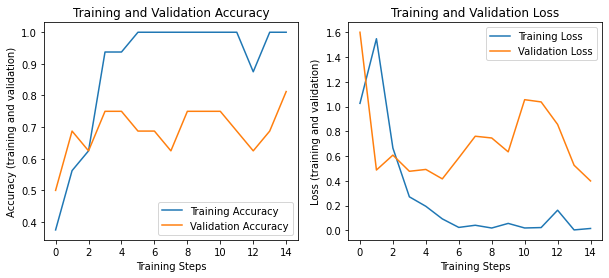

In [106]:
import matplotlib.pylab as plt
import numpy as np

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.ylabel("Accuracy (training and validation)")
plt.xlabel("Training Steps")

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.ylabel("Loss (training and validation)")
plt.xlabel("Training Steps")
plt.show()

class: Benign, confidence: 0.785979


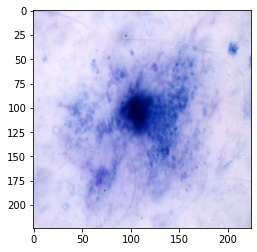

<Figure size 432x288 with 0 Axes>

class: Benign, confidence: 0.994228


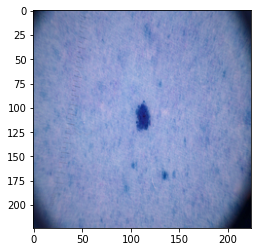

class: Malignant, confidence: 0.720996


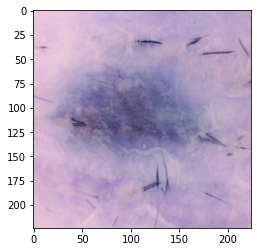

<Figure size 432x288 with 0 Axes>

class: Benign, confidence: 0.566148


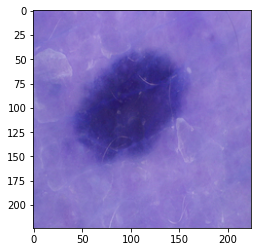

<Figure size 432x288 with 0 Axes>

class: Malignant, confidence: 0.831093


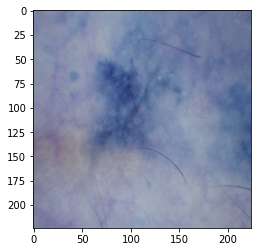

<Figure size 432x288 with 0 Axes>

class: Malignant, confidence: 0.913409


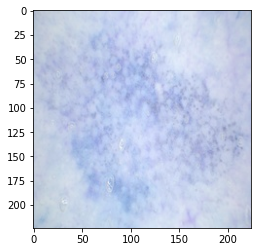

<Figure size 432x288 with 0 Axes>

class: Malignant, confidence: 0.838411


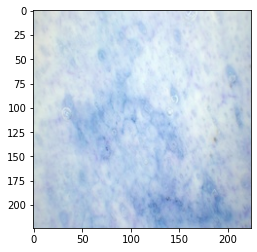

<Figure size 432x288 with 0 Axes>

class: Benign, confidence: 0.999981


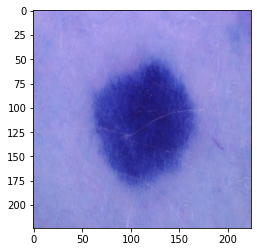

<Figure size 432x288 with 0 Axes>

class: Malignant, confidence: 0.989861


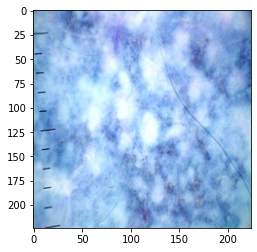

<Figure size 432x288 with 0 Axes>

class: Benign, confidence: 0.984493


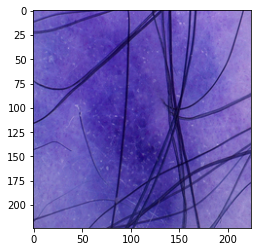

<Figure size 432x288 with 0 Axes>

class: Malignant, confidence: 0.824301


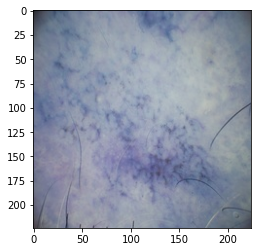

<Figure size 432x288 with 0 Axes>

class: Benign, confidence: 0.971853


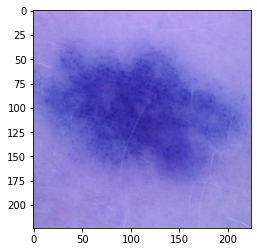

<Figure size 432x288 with 0 Axes>

class: Malignant, confidence: 0.788408


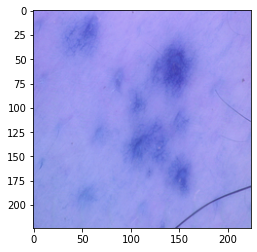

<Figure size 432x288 with 0 Axes>

class: Malignant, confidence: 0.946586


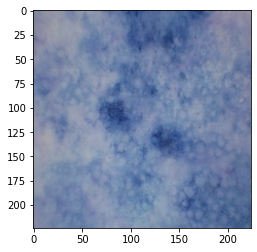

<Figure size 432x288 with 0 Axes>

class: Malignant, confidence: 0.976305


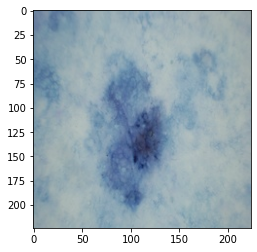

<Figure size 432x288 with 0 Axes>

class: Malignant, confidence: 0.986593


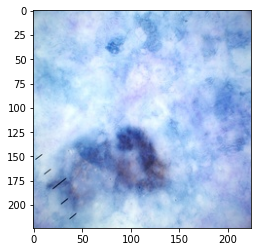

<Figure size 432x288 with 0 Axes>

In [107]:
import random
import cv2
def upload(filename):
    img = cv2.imread(os.path.join(train_dir, filename))
    img = cv2.resize(img, (224, 224) )
    img = img /255
    
    return img

def pre_result(image):
    x = model.predict(np.asarray([img]))[0]
    classx = np.argmax(x)
    
    return {Labels[classx]: x[classx]}

images = random.sample(validation_generator.filenames, 16)

for idx, filename in enumerate(images):
    
    
    img = upload(filename)
    prediction = pre_result(img)
    print("class: %s, confidence: %f" % (list(prediction.keys())[0], list(prediction.values())[0]))
    plt.imshow(img)
    plt.figure(idx)    
    plt.show()

In [108]:
from sklearn.metrics import classification_report, confusion_matrix
predictions1 = model.predict(validation_generator, steps=len(validation_generator))
y = np.argmax(predictions1, axis=1)

print('Classification Report')
cr = classification_report(y_true=validation_generator.classes, y_pred=y, target_names=validation_generator.class_indices)
print(cr)

evaluates = model.evaluate(validation_generator)

print(evaluates)

Classification Report
              precision    recall  f1-score   support

      benign       0.70      0.88      0.78         8
   malignant       0.83      0.62      0.71         8

    accuracy                           0.75        16
   macro avg       0.77      0.75      0.75        16
weighted avg       0.77      0.75      0.75        16

1/1 [==============================] - 1s 719ms/step - loss: 0.5169 - accuracy: 0.6875
[0.5169069766998291, 0.6875]


Confusion Matrix


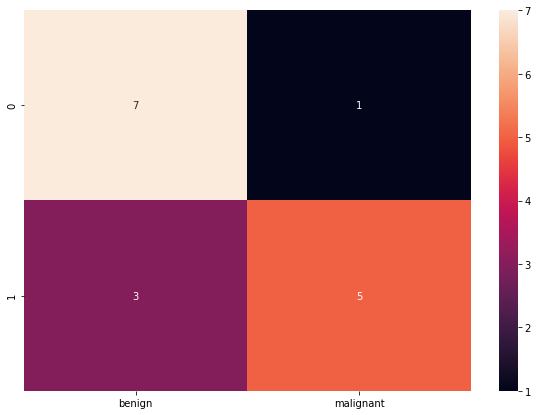

In [109]:
import pandas as pd
import numpy as np
import seaborn as sn
print('Confusion Matrix')
cm = confusion_matrix(validation_generator.classes, y)
df = pd.DataFrame(cm, columns=validation_generator.class_indices)
plt.figure(figsize=(10,7))
sn.heatmap(df, annot=True)

In [110]:
cd /content/drive/MyDrive/Buffml/code

/content/drive/MyDrive/Buffml/code


#Export as saved model and convert to TFLite

In [115]:
import time
t = time.time()

export_path = "/tmp/saved_models/{}".format(int(t))
tf.keras.models.save_model(model, export_path)

export_path

INFO:tensorflow:Assets written to: /tmp/saved_models/1622543407/assets


INFO:tensorflow:Assets written to: /tmp/saved_models/1622543407/assets


'/tmp/saved_models/1622543407'

In [118]:
# Now confirm that we can reload it, and it still gives the same results
reloaded = tf.keras.models.load_model(export_path, custom_objects={'KerasLayer':hub.KerasLayer})

In [122]:
def predict_reload(image):
    probabilities = reloaded.predict(np.asarray([img]))[0]
    class_idx = np.argmax(probabilities)
    
    return {Labels[class_idx]: probabilities[class_idx]}

SOURCE: class: malignant, file: malignant/18.jpg
PREDICTED: class: Malignant, confidence: 0.913409


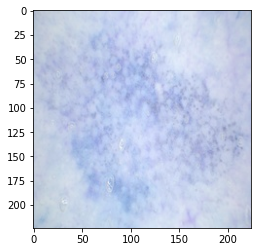

<Figure size 432x288 with 0 Axes>

SOURCE: class: malignant, file: malignant/10.jpg
PREDICTED: class: Malignant, confidence: 0.976305


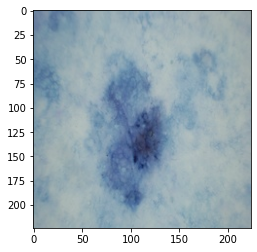

In [123]:
for idx, filename in enumerate(random.sample(validation_generator.filenames, 2)):
    print("SOURCE: class: %s, file: %s" % (os.path.split(filename)[0], filename))
    
    img = upload(filename)
    prediction = predict_reload(img)
    print("PREDICTED: class: %s, confidence: %f" % (list(prediction.keys())[0], list(prediction.values())[0]))
    plt.imshow(img)
    plt.figure(idx)    
    plt.show()

In [124]:
# convert the model to TFLite
!mkdir "tflite_models"
TFLITE_MODEL = "tflite_models/model.tflite"


# Get the concrete function from the Keras model.
run_model = tf.function(lambda x : reloaded(x))

# Save the concrete function.
concrete_func = run_model.get_concrete_function(
    tf.TensorSpec(model.inputs[0].shape, model.inputs[0].dtype)
)

# Convert the model to standard TensorFlow Lite model
converter = tf.lite.TFLiteConverter.from_concrete_functions([concrete_func])
converted_tflite_model = converter.convert()
open(TFLITE_MODEL, "wb").write(converted_tflite_model)

mkdir: cannot create directory ‘tflite_models’: File exists


11561972